In [1]:
import gensim
import os
import collections
import smart_open
import random
import multiprocessing
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from pprint import pprint
import numpy as np
from sklearn import svm
from sklearn.utils import shuffle
from keras.callbacks import ModelCheckpoint
import time

/home/hao/anaconda3/envs/MLOntology/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#global variabls

directory_path =  "/home/hao/AnacondaProjects/MLOntology/NCIt/"
data_path = directory_path + "data/"
vector_model_path = directory_path +"vectorModel/"
cnn_model_path = directory_path +"cnnModel/"


In [3]:
import re
def get_trailing_number(s):
    m = re.search(r'\d+$', s)
    return m.group() if m else None

In [4]:
#read class label file
#create mapping from id to labels  
#iso-8859-1 , encoding="iso-8859-1"
conceptLabelDict={}
errors=[]

def read_label(fname):
    with smart_open.smart_open(fname) as f:
        for i, line in enumerate(f):
            #get the id for each concept paragraph
            splitted = line.decode("iso-8859-1").split("\t")
            if len(splitted)==3:
                conceptID = get_trailing_number(splitted[1])
                conceptLabelDict[conceptID] = splitted[2].replace("\r\n", "")
            else:
                errors.append(splitted)

label_file = data_path + "ontClassLabels_owl_ncit.txt"
read_label(label_file)
print(conceptLabelDict["4863"])
print(conceptLabelDict["115117"])
print(errors)

prostate carcinoma
stage ia esophageal cancer ajcc v7
[]


In [5]:
conceptPairDict={}
errors=[]
conceptPairList=[]

def read_pair(fname):
    with smart_open.smart_open(fname) as f:
        for i, line in enumerate(f):
            #get the id for each concept paragraph
            splitted = line.decode("iso-8859-1").split("\t")
            if len(splitted)==3:
                childID = get_trailing_number(splitted[1])
                parentID = get_trailing_number(splitted[2].replace("\r\n", ""))
                conceptPairList.append([childID, parentID , 1])
#                 conceptPairDict[splitted[1]] = splitted[2].replace("\r\n", "")
            else:
                errors.append(splitted)

pair_file = data_path + "ontHierarchy_owl_ncit.txt"
read_pair(pair_file)

checkpairs = conceptPairList[10:15]
print(checkpairs)
print(len(conceptPairList))

[['4861', '7318', 1], ['87152', '87150', 1], ['87153', '140032', 1], ['87154', '87153', 1], ['87155', '87153', 1]]
16533


In [30]:
conceptNotPairDict={}
conceptNotPairList=[]

def read_not_pair(fname):
    with smart_open.smart_open(fname) as f:
        for i, line in enumerate(f):
            #get the id for each concept paragraph
            splitted = line.decode("iso-8859-1").split("\t")
            if len(splitted)==2:
                childID = get_trailing_number(splitted[0])
                notparentID = get_trailing_number(splitted[1].replace("\r\n", ""))
                conceptNotPairList.append([childID, notparentID, 0])
#                 conceptNotPairDict[splitted[1]] = splitted[2].replace("\r\n", "")
            else:
                errors.append(splitted)

notPair_file = data_path + "taxNotPairs_owl_ncit.txt"
read_not_pair(notPair_file)


first2pairs =conceptNotPairList[10:15]
print(first2pairs)
print(len(conceptNotPairList))

[['7918', '9151', 0], ['7918', '48612', 0], ['7918', '48613', 0], ['7918', '91231', 0], ['7918', '66753', 0]]
37147


In [ ]:
if len(conceptPairList) < len(conceptNotPairList):
    # In-place shuffle
    random.shuffle(conceptNotPairList)
    leftPairList = conceptNotPairList[len(conceptPairList):]
    conceptNotPairList = conceptNotPairList[:len(conceptPairList)]
else:
    # In-place shuffle
    random.shuffle(conceptPairList)
    leftPairList = conceptPairList[len(conceptNotPairList):]
    conceptPairList = conceptPairList[:len(conceptNotPairList)]

assert len(conceptPairList) == len(conceptNotPairList), "Mistmatch in Positive & Negative samples!"


In [ ]:
#  PV-DBOW
vector_model_file = vector_model_path + "model0"

vector_model = gensim.models.Doc2Vec.load(vector_model_file)

inferred_vector = vector_model.infer_vector(['congenital', 'prolong', 'rupture', 'premature', 'membrane', 'lung'])
pprint(vector_model.docvecs.most_similar([inferred_vector], topn=10))

In [9]:
# PV-DM seems better??
vector_model_file = vector_model_path + "model1"

vector_model = gensim.models.Doc2Vec.load(vector_model_file)

inferred_vector = vector_model.infer_vector(['congenital', 'prolong', 'rupture', 'premature', 'membrane', 'lung'])
pprint(vector_model.docvecs.most_similar([inferred_vector], topn=10))

[('4562', 0.5110473036766052),
 ('8965', 0.5082885026931763),
 ('3694', 0.48606282472610474),
 ('7158', 0.4841355085372925),
 ('4557', 0.47985395789146423),
 ('114940', 0.4584718644618988),
 ('5665', 0.4515834152698517),
 ('3436', 0.4509294629096985),
 ('3591', 0.44802719354629517),
 ('5365', 0.44559526443481445)]


In [10]:
vector_model.docvecs['7918']

array([ 0.07561015,  0.02476902,  0.02680791,  0.04663606, -0.02308931,
        0.00273256,  0.02592583, -0.00511803, -0.01081414,  0.04052266,
        0.00977693,  0.02226544, -0.00642227,  0.00152076,  0.08932353,
        0.04319866, -0.0290644 , -0.04120975, -0.0339289 , -0.09660215,
        0.00379683,  0.05557431,  0.0254581 , -0.04196521, -0.03251678,
       -0.00064977, -0.00879148,  0.08517931, -0.0538437 , -0.00815428,
       -0.01041271,  0.01257321,  0.03763605, -0.00137575,  0.0144251 ,
        0.02962026, -0.00505007,  0.01739127, -0.00014261, -0.01302628,
        0.01067054, -0.02067942, -0.00211267, -0.0063686 ,  0.08133038,
       -0.00894076,  0.02153996,  0.02046712,  0.01976391, -0.0314567 ,
        0.11666899,  0.00541792,  0.03735263, -0.00712609, -0.07326233,
        0.04034022,  0.01638605, -0.01436756,  0.029673  ,  0.02092113,
        0.0021104 , -0.04437225, -0.02569333, -0.02881821,  0.00826573,
        0.02594067, -0.07852481,  0.04899246, -0.04814073,  0.01

In [11]:
def readFromPairList(id_pair_list, id_notPair_list):
    pair_list = id_pair_list + id_notPair_list
    random.shuffle(pair_list)
    idpairs_list =[]
    label_list =[]
    for i, line in enumerate(pair_list):      
        idpairs_list.append([line[0], line[1]])
        label_list.append(line[2])
    return idpairs_list, label_list

idpairs_list, label_list= readFromPairList(conceptPairList, conceptNotPairList)

print(label_list[:20])

[1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0]


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(idpairs_list, label_list, test_size = 0.2, shuffle= True)
print(X_train[:20])
print(X_validation[:20])
print(y_train[:20])
print(y_validation[:20])

[['5439', '4585'], ['40316', '40016'], ['134299', '134297'], ['6779', '7048'], ['8249', '8692'], ['5127', '3328'], ['136619', '136612'], ['8133', '3464'], ['27515', '7147'], ['4618', '3193'], ['5526', '8815'], ['8891', '62279'], ['43602', '7720'], ['128295', '3011'], ['140521', '140522'], ['27245', '6509'], ['45687', '3547'], ['139876', '139871'], ['43589', '2955'], ['40145', '7359']]
[['2856', '87778'], ['27431', '9407'], ['7266', '9481'], ['89023', '35692'], ['5293', '5274'], ['2956', '4787'], ['5186', '27495'], ['43553', '5340'], ['6346', '3727'], ['4195', '3641'], ['133802', '133800'], ['3403', '121619'], ['136651', '4029'], ['8297', '3458'], ['7291', '3498'], ['87812', '135155'], ['4260', '49166'], ['5870', '27791'], ['67455', '7270'], ['136518', '94764']]
[1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]


In [13]:
def getVectorFromModel(concept_id, conceptLabelDict, model):
    if concept_id in model.docvecs:
        concept_vector= model.docvecs[concept_id]
    else:
        print("%s not found, get inferred vector "%(concept_id))
        concept_label = conceptLabelDict[concept_id]
        concept_vector= model.infer_vector(concept_label.split())
    return concept_vector

def getVector(line, conceptLabelDict, model):        
    a = getVectorFromModel(line[0], conceptLabelDict, model)
    b = getVectorFromModel(line[1], conceptLabelDict, model)
    c = np.array((a, b))
    c = c.T 
#     c = np.expand_dims(c, axis=2)
#     print(c.shape)
    return c

In [14]:
def stackVector(vector):
    from numpy import dstack
    return dstack((vector, vector, vector))

In [15]:
n_channels=2 

def get_batches(x_samples, y_samples, batch_size=64):
    samples = list(zip(x_samples, y_samples))
    num_samples = len(samples)
    
    shuffle(samples)
    for offset in range(0, num_samples, batch_size):
        batch_samples = samples[offset:offset+batch_size]

        X_samples = []
        Y_samples= []
        for batch_sample in batch_samples:
            pair_list = batch_sample[0]
            data_vector = getVector(pair_list, conceptLabelDict, vector_model)
#                 data_vector = stackVector(data_vector)
#                 print(data_vector.shape)
            X_samples.append(data_vector)
            class_label = batch_sample[1] 
            Y_samples.append(class_label)

        X_samples = np.array(X_samples).astype('float32')
        Y_samples = np.eye(n_channels)[Y_samples]
#             print('one batch ready')
        yield shuffle(X_samples, Y_samples)

def get_batches(X, y, batch_size = 100):
    """ Return a generator for batches """
    n_batches = len(X) // batch_size
    X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], y[b:b+batch_size]

In [16]:
# Imports
import tensorflow as tf

# build the model??
batch_size = 1000       # Batch size
seq_len = 128          # Number of steps
learning_rate = 0.0001
epochs = 1000

n_classes = 2
n_channels = 2


graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

    
with graph.as_default():
    # (batch, 128, 2) --> (batch, 64, 18)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=18, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
    
    # (batch, 64, 18) --> (batch, 32, 36)
    conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=36, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
    
    # (batch, 32, 36) --> (batch, 16, 72)
    conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=72, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
    
    # (batch, 16, 72) --> (batch, 8, 144)
    conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=144, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')


with graph.as_default():
    # Flatten and add dropout
    flat = tf.reshape(max_pool_4, (-1, 8*144))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat, n_classes)
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')



Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [17]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn

In [21]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    training_start_time = time.time()
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_train, y_train, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 50 iters
            if (iteration % 50 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc)
                      )
            
            # Compute validation loss at every 100 iterations
            if (iteration%100 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_validation, y_validation, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    training_duration = time.time() - training_start_time
    print("Total training time: {} sec".format(training_duration))
    saver.save(sess,"checkpoints-cnn/har.ckpt")

Epoch: 0/1000 Iteration: 50 Train loss: 0.694359 Train acc: 0.475000
Epoch: 0/1000 Iteration: 100 Train loss: 0.691766 Train acc: 0.580000
Epoch: 0/1000 Iteration: 100 Validation loss: 0.687851 Validation acc: 0.592857
Epoch: 1/1000 Iteration: 150 Train loss: 0.680949 Train acc: 0.585000
Epoch: 1/1000 Iteration: 200 Train loss: 0.694530 Train acc: 0.530000
Epoch: 1/1000 Iteration: 200 Validation loss: 0.678630 Validation acc: 0.594328
Epoch: 1/1000 Iteration: 250 Train loss: 0.674952 Train acc: 0.590000
Epoch: 2/1000 Iteration: 300 Train loss: 0.655706 Train acc: 0.610000
Epoch: 2/1000 Iteration: 300 Validation loss: 0.664546 Validation acc: 0.598214
Epoch: 2/1000 Iteration: 350 Train loss: 0.667878 Train acc: 0.535000
Epoch: 3/1000 Iteration: 400 Train loss: 0.673893 Train acc: 0.580000
Epoch: 3/1000 Iteration: 400 Validation loss: 0.652842 Validation acc: 0.614727
Epoch: 3/1000 Iteration: 450 Train loss: 0.672404 Train acc: 0.580000
Epoch: 3/1000 Iteration: 500 Train loss: 0.627030 T

Epoch: 27/1000 Iteration: 3700 Validation loss: 0.568657 Validation acc: 0.703298
Epoch: 28/1000 Iteration: 3750 Train loss: 0.591625 Train acc: 0.690000
Epoch: 28/1000 Iteration: 3800 Train loss: 0.523360 Train acc: 0.720000
Epoch: 28/1000 Iteration: 3800 Validation loss: 0.566707 Validation acc: 0.706240
Epoch: 28/1000 Iteration: 3850 Train loss: 0.581175 Train acc: 0.740000
Epoch: 29/1000 Iteration: 3900 Train loss: 0.565560 Train acc: 0.710000
Epoch: 29/1000 Iteration: 3900 Validation loss: 0.565566 Validation acc: 0.705504
Epoch: 29/1000 Iteration: 3950 Train loss: 0.556192 Train acc: 0.700000
Epoch: 30/1000 Iteration: 4000 Train loss: 0.650244 Train acc: 0.705000
Epoch: 30/1000 Iteration: 4000 Validation loss: 0.564045 Validation acc: 0.707857
Epoch: 30/1000 Iteration: 4050 Train loss: 0.576053 Train acc: 0.700000
Epoch: 30/1000 Iteration: 4100 Train loss: 0.579532 Train acc: 0.690000
Epoch: 30/1000 Iteration: 4100 Validation loss: 0.562238 Validation acc: 0.710504
Epoch: 31/1000

Epoch: 55/1000 Iteration: 7350 Train loss: 0.585243 Train acc: 0.695000
Epoch: 55/1000 Iteration: 7400 Train loss: 0.569621 Train acc: 0.695000
Epoch: 55/1000 Iteration: 7400 Validation loss: 0.528683 Validation acc: 0.734622
Epoch: 56/1000 Iteration: 7450 Train loss: 0.502127 Train acc: 0.735000
Epoch: 56/1000 Iteration: 7500 Train loss: 0.557659 Train acc: 0.700000
Epoch: 56/1000 Iteration: 7500 Validation loss: 0.527881 Validation acc: 0.732416
Epoch: 56/1000 Iteration: 7550 Train loss: 0.564432 Train acc: 0.725000
Epoch: 57/1000 Iteration: 7600 Train loss: 0.566185 Train acc: 0.710000
Epoch: 57/1000 Iteration: 7600 Validation loss: 0.528276 Validation acc: 0.739475
Epoch: 57/1000 Iteration: 7650 Train loss: 0.487270 Train acc: 0.780000
Epoch: 57/1000 Iteration: 7700 Train loss: 0.573750 Train acc: 0.685000
Epoch: 57/1000 Iteration: 7700 Validation loss: 0.525287 Validation acc: 0.736975
Epoch: 58/1000 Iteration: 7750 Train loss: 0.547421 Train acc: 0.720000
Epoch: 58/1000 Iteration

Epoch: 82/1000 Iteration: 11000 Train loss: 0.538294 Train acc: 0.755000
Epoch: 82/1000 Iteration: 11000 Validation loss: 0.509078 Validation acc: 0.748740
Epoch: 83/1000 Iteration: 11050 Train loss: 0.438444 Train acc: 0.795000
Epoch: 83/1000 Iteration: 11100 Train loss: 0.527838 Train acc: 0.725000
Epoch: 83/1000 Iteration: 11100 Validation loss: 0.504267 Validation acc: 0.752563
Epoch: 83/1000 Iteration: 11150 Train loss: 0.505270 Train acc: 0.750000
Epoch: 84/1000 Iteration: 11200 Train loss: 0.556875 Train acc: 0.705000
Epoch: 84/1000 Iteration: 11200 Validation loss: 0.503062 Validation acc: 0.752269
Epoch: 84/1000 Iteration: 11250 Train loss: 0.471178 Train acc: 0.775000
Epoch: 84/1000 Iteration: 11300 Train loss: 0.531681 Train acc: 0.715000
Epoch: 84/1000 Iteration: 11300 Validation loss: 0.507887 Validation acc: 0.748445
Epoch: 85/1000 Iteration: 11350 Train loss: 0.544549 Train acc: 0.710000
Epoch: 85/1000 Iteration: 11400 Train loss: 0.516336 Train acc: 0.715000
Epoch: 85/1

Epoch: 109/1000 Iteration: 14550 Train loss: 0.545966 Train acc: 0.715000
Epoch: 109/1000 Iteration: 14600 Train loss: 0.569296 Train acc: 0.685000
Epoch: 109/1000 Iteration: 14600 Validation loss: 0.493808 Validation acc: 0.758739
Epoch: 110/1000 Iteration: 14650 Train loss: 0.459657 Train acc: 0.805000
Epoch: 110/1000 Iteration: 14700 Train loss: 0.486552 Train acc: 0.755000
Epoch: 110/1000 Iteration: 14700 Validation loss: 0.487870 Validation acc: 0.762710
Epoch: 110/1000 Iteration: 14750 Train loss: 0.483299 Train acc: 0.720000
Epoch: 111/1000 Iteration: 14800 Train loss: 0.490724 Train acc: 0.740000
Epoch: 111/1000 Iteration: 14800 Validation loss: 0.487288 Validation acc: 0.763592
Epoch: 111/1000 Iteration: 14850 Train loss: 0.490470 Train acc: 0.775000
Epoch: 112/1000 Iteration: 14900 Train loss: 0.483634 Train acc: 0.755000
Epoch: 112/1000 Iteration: 14900 Validation loss: 0.490141 Validation acc: 0.761828
Epoch: 112/1000 Iteration: 14950 Train loss: 0.516685 Train acc: 0.72500

Epoch: 136/1000 Iteration: 18100 Train loss: 0.444720 Train acc: 0.795000
Epoch: 136/1000 Iteration: 18100 Validation loss: 0.475398 Validation acc: 0.769622
Epoch: 136/1000 Iteration: 18150 Train loss: 0.489894 Train acc: 0.710000
Epoch: 136/1000 Iteration: 18200 Train loss: 0.449955 Train acc: 0.780000
Epoch: 136/1000 Iteration: 18200 Validation loss: 0.475332 Validation acc: 0.768004
Epoch: 137/1000 Iteration: 18250 Train loss: 0.468559 Train acc: 0.760000
Epoch: 137/1000 Iteration: 18300 Train loss: 0.461220 Train acc: 0.790000
Epoch: 137/1000 Iteration: 18300 Validation loss: 0.477472 Validation acc: 0.767857
Epoch: 137/1000 Iteration: 18350 Train loss: 0.484754 Train acc: 0.770000
Epoch: 138/1000 Iteration: 18400 Train loss: 0.477907 Train acc: 0.755000
Epoch: 138/1000 Iteration: 18400 Validation loss: 0.474478 Validation acc: 0.769622
Epoch: 138/1000 Iteration: 18450 Train loss: 0.494834 Train acc: 0.775000
Epoch: 139/1000 Iteration: 18500 Train loss: 0.431349 Train acc: 0.78500

Epoch: 162/1000 Iteration: 21600 Validation loss: 0.469683 Validation acc: 0.774622
Epoch: 162/1000 Iteration: 21650 Train loss: 0.512587 Train acc: 0.780000
Epoch: 163/1000 Iteration: 21700 Train loss: 0.482410 Train acc: 0.770000
Epoch: 163/1000 Iteration: 21700 Validation loss: 0.466084 Validation acc: 0.773445
Epoch: 163/1000 Iteration: 21750 Train loss: 0.523690 Train acc: 0.730000
Epoch: 163/1000 Iteration: 21800 Train loss: 0.478715 Train acc: 0.790000
Epoch: 163/1000 Iteration: 21800 Validation loss: 0.466782 Validation acc: 0.775210
Epoch: 164/1000 Iteration: 21850 Train loss: 0.430961 Train acc: 0.800000
Epoch: 164/1000 Iteration: 21900 Train loss: 0.504256 Train acc: 0.725000
Epoch: 164/1000 Iteration: 21900 Validation loss: 0.478516 Validation acc: 0.768298
Epoch: 165/1000 Iteration: 21950 Train loss: 0.508695 Train acc: 0.775000
Epoch: 165/1000 Iteration: 22000 Train loss: 0.482438 Train acc: 0.760000
Epoch: 165/1000 Iteration: 22000 Validation loss: 0.470472 Validation ac

Epoch: 189/1000 Iteration: 25150 Train loss: 0.447391 Train acc: 0.805000
Epoch: 189/1000 Iteration: 25200 Train loss: 0.394536 Train acc: 0.860000
Epoch: 189/1000 Iteration: 25200 Validation loss: 0.459121 Validation acc: 0.777122
Epoch: 189/1000 Iteration: 25250 Train loss: 0.442473 Train acc: 0.755000
Epoch: 190/1000 Iteration: 25300 Train loss: 0.506615 Train acc: 0.770000
Epoch: 190/1000 Iteration: 25300 Validation loss: 0.461469 Validation acc: 0.776639
Epoch: 190/1000 Iteration: 25350 Train loss: 0.521253 Train acc: 0.770000
Epoch: 190/1000 Iteration: 25400 Train loss: 0.461847 Train acc: 0.800000
Epoch: 190/1000 Iteration: 25400 Validation loss: 0.458400 Validation acc: 0.777269
Epoch: 191/1000 Iteration: 25450 Train loss: 0.398088 Train acc: 0.815000
Epoch: 191/1000 Iteration: 25500 Train loss: 0.480754 Train acc: 0.785000
Epoch: 191/1000 Iteration: 25500 Validation loss: 0.459635 Validation acc: 0.780210
Epoch: 192/1000 Iteration: 25550 Train loss: 0.455640 Train acc: 0.78500

Epoch: 215/1000 Iteration: 28700 Train loss: 0.451292 Train acc: 0.785000
Epoch: 215/1000 Iteration: 28700 Validation loss: 0.452903 Validation acc: 0.777374
Epoch: 216/1000 Iteration: 28750 Train loss: 0.487538 Train acc: 0.750000
Epoch: 216/1000 Iteration: 28800 Train loss: 0.441462 Train acc: 0.780000
Epoch: 216/1000 Iteration: 28800 Validation loss: 0.452583 Validation acc: 0.781933
Epoch: 216/1000 Iteration: 28850 Train loss: 0.380130 Train acc: 0.850000
Epoch: 217/1000 Iteration: 28900 Train loss: 0.502443 Train acc: 0.795000
Epoch: 217/1000 Iteration: 28900 Validation loss: 0.452078 Validation acc: 0.780315
Epoch: 217/1000 Iteration: 28950 Train loss: 0.478828 Train acc: 0.750000
Epoch: 218/1000 Iteration: 29000 Train loss: 0.453464 Train acc: 0.790000
Epoch: 218/1000 Iteration: 29000 Validation loss: 0.454116 Validation acc: 0.777815
Epoch: 218/1000 Iteration: 29050 Train loss: 0.456986 Train acc: 0.800000
Epoch: 218/1000 Iteration: 29100 Train loss: 0.398958 Train acc: 0.82500

Epoch: 242/1000 Iteration: 32200 Validation loss: 0.450199 Validation acc: 0.778992
Epoch: 242/1000 Iteration: 32250 Train loss: 0.521267 Train acc: 0.720000
Epoch: 242/1000 Iteration: 32300 Train loss: 0.447548 Train acc: 0.750000
Epoch: 242/1000 Iteration: 32300 Validation loss: 0.447491 Validation acc: 0.781050
Epoch: 243/1000 Iteration: 32350 Train loss: 0.488985 Train acc: 0.770000
Epoch: 243/1000 Iteration: 32400 Train loss: 0.406283 Train acc: 0.850000
Epoch: 243/1000 Iteration: 32400 Validation loss: 0.451362 Validation acc: 0.785063
Epoch: 243/1000 Iteration: 32450 Train loss: 0.476754 Train acc: 0.785000
Epoch: 244/1000 Iteration: 32500 Train loss: 0.455174 Train acc: 0.795000
Epoch: 244/1000 Iteration: 32500 Validation loss: 0.449991 Validation acc: 0.785504
Epoch: 244/1000 Iteration: 32550 Train loss: 0.448647 Train acc: 0.805000
Epoch: 245/1000 Iteration: 32600 Train loss: 0.412845 Train acc: 0.810000
Epoch: 245/1000 Iteration: 32600 Validation loss: 0.451984 Validation ac

Epoch: 268/1000 Iteration: 35750 Train loss: 0.405129 Train acc: 0.795000
Epoch: 269/1000 Iteration: 35800 Train loss: 0.414482 Train acc: 0.790000
Epoch: 269/1000 Iteration: 35800 Validation loss: 0.443592 Validation acc: 0.787962
Epoch: 269/1000 Iteration: 35850 Train loss: 0.397088 Train acc: 0.790000
Epoch: 269/1000 Iteration: 35900 Train loss: 0.365923 Train acc: 0.850000
Epoch: 269/1000 Iteration: 35900 Validation loss: 0.443385 Validation acc: 0.783109
Epoch: 270/1000 Iteration: 35950 Train loss: 0.398135 Train acc: 0.830000
Epoch: 270/1000 Iteration: 36000 Train loss: 0.465251 Train acc: 0.765000
Epoch: 270/1000 Iteration: 36000 Validation loss: 0.446734 Validation acc: 0.782374
Epoch: 271/1000 Iteration: 36050 Train loss: 0.404125 Train acc: 0.805000
Epoch: 271/1000 Iteration: 36100 Train loss: 0.391517 Train acc: 0.835000
Epoch: 271/1000 Iteration: 36100 Validation loss: 0.451650 Validation acc: 0.778550
Epoch: 271/1000 Iteration: 36150 Train loss: 0.436882 Train acc: 0.79000

Epoch: 295/1000 Iteration: 39300 Train loss: 0.435810 Train acc: 0.825000
Epoch: 295/1000 Iteration: 39300 Validation loss: 0.440003 Validation acc: 0.788109
Epoch: 295/1000 Iteration: 39350 Train loss: 0.421041 Train acc: 0.795000
Epoch: 296/1000 Iteration: 39400 Train loss: 0.438372 Train acc: 0.805000
Epoch: 296/1000 Iteration: 39400 Validation loss: 0.441279 Validation acc: 0.786197
Epoch: 296/1000 Iteration: 39450 Train loss: 0.495183 Train acc: 0.720000
Epoch: 296/1000 Iteration: 39500 Train loss: 0.378292 Train acc: 0.840000
Epoch: 296/1000 Iteration: 39500 Validation loss: 0.441005 Validation acc: 0.785315
Epoch: 297/1000 Iteration: 39550 Train loss: 0.407213 Train acc: 0.790000
Epoch: 297/1000 Iteration: 39600 Train loss: 0.455451 Train acc: 0.790000
Epoch: 297/1000 Iteration: 39600 Validation loss: 0.445278 Validation acc: 0.782374
Epoch: 298/1000 Iteration: 39650 Train loss: 0.431889 Train acc: 0.790000
Epoch: 298/1000 Iteration: 39700 Train loss: 0.423004 Train acc: 0.81500

Epoch: 321/1000 Iteration: 42800 Validation loss: 0.436207 Validation acc: 0.788845
Epoch: 322/1000 Iteration: 42850 Train loss: 0.448005 Train acc: 0.795000
Epoch: 322/1000 Iteration: 42900 Train loss: 0.381710 Train acc: 0.800000
Epoch: 322/1000 Iteration: 42900 Validation loss: 0.437039 Validation acc: 0.790462
Epoch: 322/1000 Iteration: 42950 Train loss: 0.415276 Train acc: 0.785000
Epoch: 323/1000 Iteration: 43000 Train loss: 0.431210 Train acc: 0.805000
Epoch: 323/1000 Iteration: 43000 Validation loss: 0.436292 Validation acc: 0.790903
Epoch: 323/1000 Iteration: 43050 Train loss: 0.392345 Train acc: 0.815000
Epoch: 324/1000 Iteration: 43100 Train loss: 0.451230 Train acc: 0.765000
Epoch: 324/1000 Iteration: 43100 Validation loss: 0.437319 Validation acc: 0.789139
Epoch: 324/1000 Iteration: 43150 Train loss: 0.410257 Train acc: 0.800000
Epoch: 324/1000 Iteration: 43200 Train loss: 0.415975 Train acc: 0.830000
Epoch: 324/1000 Iteration: 43200 Validation loss: 0.438766 Validation ac

Epoch: 348/1000 Iteration: 46350 Train loss: 0.460259 Train acc: 0.755000
Epoch: 348/1000 Iteration: 46400 Train loss: 0.370682 Train acc: 0.810000
Epoch: 348/1000 Iteration: 46400 Validation loss: 0.436169 Validation acc: 0.790021
Epoch: 349/1000 Iteration: 46450 Train loss: 0.440752 Train acc: 0.820000
Epoch: 349/1000 Iteration: 46500 Train loss: 0.357893 Train acc: 0.830000
Epoch: 349/1000 Iteration: 46500 Validation loss: 0.435491 Validation acc: 0.791933
Epoch: 349/1000 Iteration: 46550 Train loss: 0.320229 Train acc: 0.865385
Epoch: 350/1000 Iteration: 46600 Train loss: 0.362153 Train acc: 0.825000
Epoch: 350/1000 Iteration: 46600 Validation loss: 0.438129 Validation acc: 0.789433
Epoch: 350/1000 Iteration: 46650 Train loss: 0.392470 Train acc: 0.815000
Epoch: 351/1000 Iteration: 46700 Train loss: 0.410300 Train acc: 0.820000
Epoch: 351/1000 Iteration: 46700 Validation loss: 0.437414 Validation acc: 0.788550
Epoch: 351/1000 Iteration: 46750 Train loss: 0.466022 Train acc: 0.80500

Epoch: 375/1000 Iteration: 49900 Train loss: 0.383574 Train acc: 0.840000
Epoch: 375/1000 Iteration: 49900 Validation loss: 0.431819 Validation acc: 0.794874
Epoch: 375/1000 Iteration: 49950 Train loss: 0.356331 Train acc: 0.825000
Epoch: 375/1000 Iteration: 50000 Train loss: 0.412671 Train acc: 0.830000
Epoch: 375/1000 Iteration: 50000 Validation loss: 0.433326 Validation acc: 0.791681
Epoch: 376/1000 Iteration: 50050 Train loss: 0.438300 Train acc: 0.805000
Epoch: 376/1000 Iteration: 50100 Train loss: 0.393394 Train acc: 0.820000
Epoch: 376/1000 Iteration: 50100 Validation loss: 0.438904 Validation acc: 0.791681
Epoch: 377/1000 Iteration: 50150 Train loss: 0.388368 Train acc: 0.810000
Epoch: 377/1000 Iteration: 50200 Train loss: 0.421003 Train acc: 0.805000
Epoch: 377/1000 Iteration: 50200 Validation loss: 0.430246 Validation acc: 0.793697
Epoch: 377/1000 Iteration: 50250 Train loss: 0.383876 Train acc: 0.810000
Epoch: 378/1000 Iteration: 50300 Train loss: 0.452899 Train acc: 0.79500

Epoch: 401/1000 Iteration: 53400 Validation loss: 0.428861 Validation acc: 0.793550
Epoch: 401/1000 Iteration: 53450 Train loss: 0.397020 Train acc: 0.820000
Epoch: 402/1000 Iteration: 53500 Train loss: 0.417077 Train acc: 0.805000
Epoch: 402/1000 Iteration: 53500 Validation loss: 0.428951 Validation acc: 0.795903
Epoch: 402/1000 Iteration: 53550 Train loss: 0.364333 Train acc: 0.835000
Epoch: 403/1000 Iteration: 53600 Train loss: 0.401486 Train acc: 0.790000
Epoch: 403/1000 Iteration: 53600 Validation loss: 0.428858 Validation acc: 0.795756
Epoch: 403/1000 Iteration: 53650 Train loss: 0.414772 Train acc: 0.810000
Epoch: 403/1000 Iteration: 53700 Train loss: 0.372517 Train acc: 0.795000
Epoch: 403/1000 Iteration: 53700 Validation loss: 0.437707 Validation acc: 0.791387
Epoch: 404/1000 Iteration: 53750 Train loss: 0.347728 Train acc: 0.830000
Epoch: 404/1000 Iteration: 53800 Train loss: 0.390691 Train acc: 0.810000
Epoch: 404/1000 Iteration: 53800 Validation loss: 0.429548 Validation ac

Epoch: 428/1000 Iteration: 56950 Train loss: 0.398499 Train acc: 0.825000
Epoch: 428/1000 Iteration: 57000 Train loss: 0.380633 Train acc: 0.820000
Epoch: 428/1000 Iteration: 57000 Validation loss: 0.427849 Validation acc: 0.794580
Epoch: 428/1000 Iteration: 57050 Train loss: 0.344635 Train acc: 0.870000
Epoch: 429/1000 Iteration: 57100 Train loss: 0.350549 Train acc: 0.810000
Epoch: 429/1000 Iteration: 57100 Validation loss: 0.427741 Validation acc: 0.794916
Epoch: 429/1000 Iteration: 57150 Train loss: 0.372319 Train acc: 0.815000
Epoch: 430/1000 Iteration: 57200 Train loss: 0.389818 Train acc: 0.825000
Epoch: 430/1000 Iteration: 57200 Validation loss: 0.427070 Validation acc: 0.795168
Epoch: 430/1000 Iteration: 57250 Train loss: 0.365764 Train acc: 0.810000
Epoch: 430/1000 Iteration: 57300 Train loss: 0.368249 Train acc: 0.825000
Epoch: 430/1000 Iteration: 57300 Validation loss: 0.428116 Validation acc: 0.792374
Epoch: 431/1000 Iteration: 57350 Train loss: 0.359357 Train acc: 0.82000

Epoch: 454/1000 Iteration: 60500 Train loss: 0.385812 Train acc: 0.825000
Epoch: 454/1000 Iteration: 60500 Validation loss: 0.428702 Validation acc: 0.796534
Epoch: 455/1000 Iteration: 60550 Train loss: 0.368167 Train acc: 0.825000
Epoch: 455/1000 Iteration: 60600 Train loss: 0.360277 Train acc: 0.830000
Epoch: 455/1000 Iteration: 60600 Validation loss: 0.429618 Validation acc: 0.796387
Epoch: 456/1000 Iteration: 60650 Train loss: 0.378830 Train acc: 0.790000
Epoch: 456/1000 Iteration: 60700 Train loss: 0.365306 Train acc: 0.830000
Epoch: 456/1000 Iteration: 60700 Validation loss: 0.429793 Validation acc: 0.793004
Epoch: 456/1000 Iteration: 60750 Train loss: 0.433086 Train acc: 0.765000
Epoch: 457/1000 Iteration: 60800 Train loss: 0.435057 Train acc: 0.780000
Epoch: 457/1000 Iteration: 60800 Validation loss: 0.428714 Validation acc: 0.797122
Epoch: 457/1000 Iteration: 60850 Train loss: 0.348862 Train acc: 0.850000
Epoch: 457/1000 Iteration: 60900 Train loss: 0.364183 Train acc: 0.84000

Epoch: 481/1000 Iteration: 64000 Validation loss: 0.423686 Validation acc: 0.797080
Epoch: 481/1000 Iteration: 64050 Train loss: 0.338077 Train acc: 0.865000
Epoch: 481/1000 Iteration: 64100 Train loss: 0.416854 Train acc: 0.820000
Epoch: 481/1000 Iteration: 64100 Validation loss: 0.424102 Validation acc: 0.795798
Epoch: 482/1000 Iteration: 64150 Train loss: 0.393734 Train acc: 0.820000
Epoch: 482/1000 Iteration: 64200 Train loss: 0.356666 Train acc: 0.820000
Epoch: 482/1000 Iteration: 64200 Validation loss: 0.433196 Validation acc: 0.791092
Epoch: 483/1000 Iteration: 64250 Train loss: 0.334873 Train acc: 0.850000
Epoch: 483/1000 Iteration: 64300 Train loss: 0.352629 Train acc: 0.855000
Epoch: 483/1000 Iteration: 64300 Validation loss: 0.423422 Validation acc: 0.796534
Epoch: 483/1000 Iteration: 64350 Train loss: 0.389887 Train acc: 0.810000
Epoch: 484/1000 Iteration: 64400 Train loss: 0.366109 Train acc: 0.835000
Epoch: 484/1000 Iteration: 64400 Validation loss: 0.423626 Validation ac

Epoch: 507/1000 Iteration: 67550 Train loss: 0.383861 Train acc: 0.805000
Epoch: 508/1000 Iteration: 67600 Train loss: 0.368630 Train acc: 0.820000
Epoch: 508/1000 Iteration: 67600 Validation loss: 0.421187 Validation acc: 0.797962
Epoch: 508/1000 Iteration: 67650 Train loss: 0.333359 Train acc: 0.860000
Epoch: 509/1000 Iteration: 67700 Train loss: 0.383598 Train acc: 0.825000
Epoch: 509/1000 Iteration: 67700 Validation loss: 0.422044 Validation acc: 0.797815
Epoch: 509/1000 Iteration: 67750 Train loss: 0.349964 Train acc: 0.845000
Epoch: 509/1000 Iteration: 67800 Train loss: 0.402723 Train acc: 0.815000
Epoch: 509/1000 Iteration: 67800 Validation loss: 0.437224 Validation acc: 0.791534
Epoch: 510/1000 Iteration: 67850 Train loss: 0.342975 Train acc: 0.870000
Epoch: 510/1000 Iteration: 67900 Train loss: 0.378031 Train acc: 0.815000
Epoch: 510/1000 Iteration: 67900 Validation loss: 0.422532 Validation acc: 0.795609
Epoch: 510/1000 Iteration: 67950 Train loss: 0.377566 Train acc: 0.83500

Epoch: 534/1000 Iteration: 71100 Train loss: 0.360865 Train acc: 0.845000
Epoch: 534/1000 Iteration: 71100 Validation loss: 0.421874 Validation acc: 0.799475
Epoch: 534/1000 Iteration: 71150 Train loss: 0.380750 Train acc: 0.810000
Epoch: 535/1000 Iteration: 71200 Train loss: 0.399357 Train acc: 0.810000
Epoch: 535/1000 Iteration: 71200 Validation loss: 0.427610 Validation acc: 0.798004
Epoch: 535/1000 Iteration: 71250 Train loss: 0.340026 Train acc: 0.840000
Epoch: 536/1000 Iteration: 71300 Train loss: 0.292536 Train acc: 0.855000
Epoch: 536/1000 Iteration: 71300 Validation loss: 0.420501 Validation acc: 0.796050
Epoch: 536/1000 Iteration: 71350 Train loss: 0.364337 Train acc: 0.840000
Epoch: 536/1000 Iteration: 71400 Train loss: 0.312636 Train acc: 0.875000
Epoch: 536/1000 Iteration: 71400 Validation loss: 0.419845 Validation acc: 0.800504
Epoch: 537/1000 Iteration: 71450 Train loss: 0.328240 Train acc: 0.860000
Epoch: 537/1000 Iteration: 71500 Train loss: 0.367925 Train acc: 0.86500

Epoch: 560/1000 Iteration: 74600 Validation loss: 0.418274 Validation acc: 0.801387
Epoch: 561/1000 Iteration: 74650 Train loss: 0.357423 Train acc: 0.820000
Epoch: 561/1000 Iteration: 74700 Train loss: 0.357732 Train acc: 0.830000
Epoch: 561/1000 Iteration: 74700 Validation loss: 0.439968 Validation acc: 0.793592
Epoch: 562/1000 Iteration: 74750 Train loss: 0.350902 Train acc: 0.835000
Epoch: 562/1000 Iteration: 74800 Train loss: 0.325392 Train acc: 0.850000
Epoch: 562/1000 Iteration: 74800 Validation loss: 0.420539 Validation acc: 0.798445
Epoch: 562/1000 Iteration: 74850 Train loss: 0.360576 Train acc: 0.855000
Epoch: 563/1000 Iteration: 74900 Train loss: 0.359122 Train acc: 0.820000
Epoch: 563/1000 Iteration: 74900 Validation loss: 0.418392 Validation acc: 0.798256
Epoch: 563/1000 Iteration: 74950 Train loss: 0.405085 Train acc: 0.840000
Epoch: 563/1000 Iteration: 75000 Train loss: 0.309580 Train acc: 0.885000
Epoch: 563/1000 Iteration: 75000 Validation loss: 0.417894 Validation ac

Epoch: 587/1000 Iteration: 78150 Train loss: 0.326245 Train acc: 0.860000
Epoch: 587/1000 Iteration: 78200 Train loss: 0.332035 Train acc: 0.860000
Epoch: 587/1000 Iteration: 78200 Validation loss: 0.420617 Validation acc: 0.797668
Epoch: 588/1000 Iteration: 78250 Train loss: 0.311745 Train acc: 0.840000
Epoch: 588/1000 Iteration: 78300 Train loss: 0.406636 Train acc: 0.810000
Epoch: 588/1000 Iteration: 78300 Validation loss: 0.429051 Validation acc: 0.797710
Epoch: 589/1000 Iteration: 78350 Train loss: 0.307993 Train acc: 0.860000
Epoch: 589/1000 Iteration: 78400 Train loss: 0.311314 Train acc: 0.870000
Epoch: 589/1000 Iteration: 78400 Validation loss: 0.417757 Validation acc: 0.800945
Epoch: 589/1000 Iteration: 78450 Train loss: 0.348022 Train acc: 0.850000
Epoch: 590/1000 Iteration: 78500 Train loss: 0.374759 Train acc: 0.825000
Epoch: 590/1000 Iteration: 78500 Validation loss: 0.422593 Validation acc: 0.798592
Epoch: 590/1000 Iteration: 78550 Train loss: 0.389561 Train acc: 0.83000

Epoch: 614/1000 Iteration: 81700 Train loss: 0.302107 Train acc: 0.850000
Epoch: 614/1000 Iteration: 81700 Validation loss: 0.418251 Validation acc: 0.801534
Epoch: 614/1000 Iteration: 81750 Train loss: 0.372874 Train acc: 0.835000
Epoch: 615/1000 Iteration: 81800 Train loss: 0.368058 Train acc: 0.850000
Epoch: 615/1000 Iteration: 81800 Validation loss: 0.419168 Validation acc: 0.798004
Epoch: 615/1000 Iteration: 81850 Train loss: 0.355308 Train acc: 0.860000
Epoch: 615/1000 Iteration: 81900 Train loss: 0.285947 Train acc: 0.890000
Epoch: 615/1000 Iteration: 81900 Validation loss: 0.421937 Validation acc: 0.800105
Epoch: 616/1000 Iteration: 81950 Train loss: 0.380961 Train acc: 0.820000
Epoch: 616/1000 Iteration: 82000 Train loss: 0.336953 Train acc: 0.840000
Epoch: 616/1000 Iteration: 82000 Validation loss: 0.420991 Validation acc: 0.795462
Epoch: 616/1000 Iteration: 82050 Train loss: 0.285631 Train acc: 0.875000
Epoch: 617/1000 Iteration: 82100 Train loss: 0.411461 Train acc: 0.83500

Epoch: 640/1000 Iteration: 85200 Validation loss: 0.421227 Validation acc: 0.801387
Epoch: 640/1000 Iteration: 85250 Train loss: 0.345728 Train acc: 0.830000
Epoch: 641/1000 Iteration: 85300 Train loss: 0.314429 Train acc: 0.860000
Epoch: 641/1000 Iteration: 85300 Validation loss: 0.416533 Validation acc: 0.801828
Epoch: 641/1000 Iteration: 85350 Train loss: 0.361079 Train acc: 0.860000
Epoch: 642/1000 Iteration: 85400 Train loss: 0.317631 Train acc: 0.840000
Epoch: 642/1000 Iteration: 85400 Validation loss: 0.422527 Validation acc: 0.800105
Epoch: 642/1000 Iteration: 85450 Train loss: 0.367704 Train acc: 0.805000
Epoch: 642/1000 Iteration: 85500 Train loss: 0.370112 Train acc: 0.800000
Epoch: 642/1000 Iteration: 85500 Validation loss: 0.421005 Validation acc: 0.799664
Epoch: 643/1000 Iteration: 85550 Train loss: 0.341554 Train acc: 0.845000
Epoch: 643/1000 Iteration: 85600 Train loss: 0.304365 Train acc: 0.855000
Epoch: 643/1000 Iteration: 85600 Validation loss: 0.424376 Validation ac

Epoch: 667/1000 Iteration: 88750 Train loss: 0.407148 Train acc: 0.825000
Epoch: 667/1000 Iteration: 88800 Train loss: 0.402203 Train acc: 0.825000
Epoch: 667/1000 Iteration: 88800 Validation loss: 0.440082 Validation acc: 0.794181
Epoch: 668/1000 Iteration: 88850 Train loss: 0.372668 Train acc: 0.855000
Epoch: 668/1000 Iteration: 88900 Train loss: 0.339318 Train acc: 0.845000
Epoch: 668/1000 Iteration: 88900 Validation loss: 0.421906 Validation acc: 0.803634
Epoch: 668/1000 Iteration: 88950 Train loss: 0.334281 Train acc: 0.835000
Epoch: 669/1000 Iteration: 89000 Train loss: 0.317353 Train acc: 0.865000
Epoch: 669/1000 Iteration: 89000 Validation loss: 0.415301 Validation acc: 0.802563
Epoch: 669/1000 Iteration: 89050 Train loss: 0.338178 Train acc: 0.835000
Epoch: 669/1000 Iteration: 89100 Train loss: 0.327117 Train acc: 0.860000
Epoch: 669/1000 Iteration: 89100 Validation loss: 0.416714 Validation acc: 0.804328
Epoch: 670/1000 Iteration: 89150 Train loss: 0.323308 Train acc: 0.85000

Epoch: 693/1000 Iteration: 92300 Train loss: 0.381087 Train acc: 0.845000
Epoch: 693/1000 Iteration: 92300 Validation loss: 0.423038 Validation acc: 0.805399
Epoch: 694/1000 Iteration: 92350 Train loss: 0.358512 Train acc: 0.865000
Epoch: 694/1000 Iteration: 92400 Train loss: 0.306017 Train acc: 0.875000
Epoch: 694/1000 Iteration: 92400 Validation loss: 0.417686 Validation acc: 0.801093
Epoch: 695/1000 Iteration: 92450 Train loss: 0.299844 Train acc: 0.885000
Epoch: 695/1000 Iteration: 92500 Train loss: 0.274670 Train acc: 0.900000
Epoch: 695/1000 Iteration: 92500 Validation loss: 0.414827 Validation acc: 0.802563
Epoch: 695/1000 Iteration: 92550 Train loss: 0.339797 Train acc: 0.825000
Epoch: 696/1000 Iteration: 92600 Train loss: 0.341888 Train acc: 0.845000
Epoch: 696/1000 Iteration: 92600 Validation loss: 0.422210 Validation acc: 0.802899
Epoch: 696/1000 Iteration: 92650 Train loss: 0.412538 Train acc: 0.795000
Epoch: 696/1000 Iteration: 92700 Train loss: 0.312881 Train acc: 0.84500

Epoch: 720/1000 Iteration: 95800 Validation loss: 0.414805 Validation acc: 0.805798
Epoch: 720/1000 Iteration: 95850 Train loss: 0.330047 Train acc: 0.850000
Epoch: 721/1000 Iteration: 95900 Train loss: 0.291450 Train acc: 0.870000
Epoch: 721/1000 Iteration: 95900 Validation loss: 0.414786 Validation acc: 0.804181
Epoch: 721/1000 Iteration: 95950 Train loss: 0.283833 Train acc: 0.860000
Epoch: 721/1000 Iteration: 96000 Train loss: 0.356601 Train acc: 0.835000
Epoch: 721/1000 Iteration: 96000 Validation loss: 0.414340 Validation acc: 0.804475
Epoch: 722/1000 Iteration: 96050 Train loss: 0.342952 Train acc: 0.855000
Epoch: 722/1000 Iteration: 96100 Train loss: 0.323899 Train acc: 0.860000
Epoch: 722/1000 Iteration: 96100 Validation loss: 0.415217 Validation acc: 0.804622
Epoch: 722/1000 Iteration: 96150 Train loss: 0.296576 Train acc: 0.870000
Epoch: 723/1000 Iteration: 96200 Train loss: 0.340101 Train acc: 0.860000
Epoch: 723/1000 Iteration: 96200 Validation loss: 0.415390 Validation ac

Epoch: 746/1000 Iteration: 99350 Train loss: 0.293431 Train acc: 0.880000
Epoch: 747/1000 Iteration: 99400 Train loss: 0.276069 Train acc: 0.885000
Epoch: 747/1000 Iteration: 99400 Validation loss: 0.414128 Validation acc: 0.806092
Epoch: 747/1000 Iteration: 99450 Train loss: 0.352951 Train acc: 0.815000
Epoch: 748/1000 Iteration: 99500 Train loss: 0.337594 Train acc: 0.850000
Epoch: 748/1000 Iteration: 99500 Validation loss: 0.418041 Validation acc: 0.805651
Epoch: 748/1000 Iteration: 99550 Train loss: 0.389640 Train acc: 0.830000
Epoch: 748/1000 Iteration: 99600 Train loss: 0.280721 Train acc: 0.890000
Epoch: 748/1000 Iteration: 99600 Validation loss: 0.419877 Validation acc: 0.801828
Epoch: 749/1000 Iteration: 99650 Train loss: 0.351135 Train acc: 0.855000
Epoch: 749/1000 Iteration: 99700 Train loss: 0.318419 Train acc: 0.875000
Epoch: 749/1000 Iteration: 99700 Validation loss: 0.416386 Validation acc: 0.805945
Epoch: 749/1000 Iteration: 99750 Train loss: 0.181442 Train acc: 0.94230

Epoch: 773/1000 Iteration: 102850 Train loss: 0.348018 Train acc: 0.840000
Epoch: 773/1000 Iteration: 102900 Train loss: 0.304160 Train acc: 0.855000
Epoch: 773/1000 Iteration: 102900 Validation loss: 0.415542 Validation acc: 0.804328
Epoch: 774/1000 Iteration: 102950 Train loss: 0.395757 Train acc: 0.785000
Epoch: 774/1000 Iteration: 103000 Train loss: 0.267296 Train acc: 0.875000
Epoch: 774/1000 Iteration: 103000 Validation loss: 0.419067 Validation acc: 0.804916
Epoch: 774/1000 Iteration: 103050 Train loss: 0.301470 Train acc: 0.870000
Epoch: 775/1000 Iteration: 103100 Train loss: 0.296477 Train acc: 0.875000
Epoch: 775/1000 Iteration: 103100 Validation loss: 0.413305 Validation acc: 0.805063
Epoch: 775/1000 Iteration: 103150 Train loss: 0.263024 Train acc: 0.895000
Epoch: 775/1000 Iteration: 103200 Train loss: 0.324584 Train acc: 0.865000
Epoch: 775/1000 Iteration: 103200 Validation loss: 0.421726 Validation acc: 0.802122
Epoch: 776/1000 Iteration: 103250 Train loss: 0.285661 Train

Epoch: 799/1000 Iteration: 106350 Train loss: 0.269705 Train acc: 0.895000
Epoch: 799/1000 Iteration: 106400 Train loss: 0.129748 Train acc: 1.000000
Epoch: 799/1000 Iteration: 106400 Validation loss: 0.413619 Validation acc: 0.806092
Epoch: 800/1000 Iteration: 106450 Train loss: 0.315539 Train acc: 0.835000
Epoch: 800/1000 Iteration: 106500 Train loss: 0.296064 Train acc: 0.895000
Epoch: 800/1000 Iteration: 106500 Validation loss: 0.414707 Validation acc: 0.804916
Epoch: 801/1000 Iteration: 106550 Train loss: 0.302371 Train acc: 0.845000
Epoch: 801/1000 Iteration: 106600 Train loss: 0.352237 Train acc: 0.855000
Epoch: 801/1000 Iteration: 106600 Validation loss: 0.416448 Validation acc: 0.803445
Epoch: 801/1000 Iteration: 106650 Train loss: 0.313812 Train acc: 0.850000
Epoch: 802/1000 Iteration: 106700 Train loss: 0.327589 Train acc: 0.865000
Epoch: 802/1000 Iteration: 106700 Validation loss: 0.414289 Validation acc: 0.807710
Epoch: 802/1000 Iteration: 106750 Train loss: 0.308088 Train

Epoch: 825/1000 Iteration: 109850 Train loss: 0.284097 Train acc: 0.870000
Epoch: 826/1000 Iteration: 109900 Train loss: 0.328526 Train acc: 0.860000
Epoch: 826/1000 Iteration: 109900 Validation loss: 0.413189 Validation acc: 0.808151
Epoch: 826/1000 Iteration: 109950 Train loss: 0.273875 Train acc: 0.870000
Epoch: 827/1000 Iteration: 110000 Train loss: 0.286495 Train acc: 0.860000
Epoch: 827/1000 Iteration: 110000 Validation loss: 0.412176 Validation acc: 0.807857
Epoch: 827/1000 Iteration: 110050 Train loss: 0.337264 Train acc: 0.830000
Epoch: 827/1000 Iteration: 110100 Train loss: 0.291323 Train acc: 0.875000
Epoch: 827/1000 Iteration: 110100 Validation loss: 0.413713 Validation acc: 0.805504
Epoch: 828/1000 Iteration: 110150 Train loss: 0.314826 Train acc: 0.890000
Epoch: 828/1000 Iteration: 110200 Train loss: 0.314005 Train acc: 0.840000
Epoch: 828/1000 Iteration: 110200 Validation loss: 0.414431 Validation acc: 0.805357
Epoch: 828/1000 Iteration: 110250 Train loss: 0.315282 Train

Epoch: 852/1000 Iteration: 113350 Train loss: 0.287821 Train acc: 0.865000
Epoch: 852/1000 Iteration: 113400 Train loss: 0.321065 Train acc: 0.855000
Epoch: 852/1000 Iteration: 113400 Validation loss: 0.414552 Validation acc: 0.808151
Epoch: 853/1000 Iteration: 113450 Train loss: 0.273749 Train acc: 0.890000
Epoch: 853/1000 Iteration: 113500 Train loss: 0.285831 Train acc: 0.865000
Epoch: 853/1000 Iteration: 113500 Validation loss: 0.417377 Validation acc: 0.804181
Epoch: 853/1000 Iteration: 113550 Train loss: 0.280726 Train acc: 0.900000
Epoch: 854/1000 Iteration: 113600 Train loss: 0.275604 Train acc: 0.900000
Epoch: 854/1000 Iteration: 113600 Validation loss: 0.418067 Validation acc: 0.806828
Epoch: 854/1000 Iteration: 113650 Train loss: 0.276908 Train acc: 0.865000
Epoch: 854/1000 Iteration: 113700 Train loss: 0.330391 Train acc: 0.835000
Epoch: 854/1000 Iteration: 113700 Validation loss: 0.417434 Validation acc: 0.808445
Epoch: 855/1000 Iteration: 113750 Train loss: 0.283288 Train

Epoch: 878/1000 Iteration: 116850 Train loss: 0.322615 Train acc: 0.865000
Epoch: 878/1000 Iteration: 116900 Train loss: 0.290107 Train acc: 0.860000
Epoch: 878/1000 Iteration: 116900 Validation loss: 0.423475 Validation acc: 0.803887
Epoch: 879/1000 Iteration: 116950 Train loss: 0.282722 Train acc: 0.850000
Epoch: 879/1000 Iteration: 117000 Train loss: 0.270797 Train acc: 0.870000
Epoch: 879/1000 Iteration: 117000 Validation loss: 0.415729 Validation acc: 0.806239
Epoch: 880/1000 Iteration: 117050 Train loss: 0.286685 Train acc: 0.865000
Epoch: 880/1000 Iteration: 117100 Train loss: 0.283925 Train acc: 0.885000
Epoch: 880/1000 Iteration: 117100 Validation loss: 0.413595 Validation acc: 0.808740
Epoch: 880/1000 Iteration: 117150 Train loss: 0.291665 Train acc: 0.885000
Epoch: 881/1000 Iteration: 117200 Train loss: 0.332015 Train acc: 0.825000
Epoch: 881/1000 Iteration: 117200 Validation loss: 0.413310 Validation acc: 0.809181
Epoch: 881/1000 Iteration: 117250 Train loss: 0.289537 Train

Epoch: 904/1000 Iteration: 120350 Train loss: 0.304249 Train acc: 0.840000
Epoch: 905/1000 Iteration: 120400 Train loss: 0.273890 Train acc: 0.885000
Epoch: 905/1000 Iteration: 120400 Validation loss: 0.413283 Validation acc: 0.811387
Epoch: 905/1000 Iteration: 120450 Train loss: 0.324617 Train acc: 0.835000
Epoch: 906/1000 Iteration: 120500 Train loss: 0.307823 Train acc: 0.860000
Epoch: 906/1000 Iteration: 120500 Validation loss: 0.421351 Validation acc: 0.809181
Epoch: 906/1000 Iteration: 120550 Train loss: 0.307275 Train acc: 0.825000
Epoch: 906/1000 Iteration: 120600 Train loss: 0.340749 Train acc: 0.840000
Epoch: 906/1000 Iteration: 120600 Validation loss: 0.418249 Validation acc: 0.810546
Epoch: 907/1000 Iteration: 120650 Train loss: 0.351088 Train acc: 0.850000
Epoch: 907/1000 Iteration: 120700 Train loss: 0.250891 Train acc: 0.895000
Epoch: 907/1000 Iteration: 120700 Validation loss: 0.412801 Validation acc: 0.807563
Epoch: 907/1000 Iteration: 120750 Train loss: 0.329136 Train

Epoch: 931/1000 Iteration: 123850 Train loss: 0.320256 Train acc: 0.835000
Epoch: 931/1000 Iteration: 123900 Train loss: 0.273999 Train acc: 0.870000
Epoch: 931/1000 Iteration: 123900 Validation loss: 0.412822 Validation acc: 0.806387
Epoch: 931/1000 Iteration: 123950 Train loss: 0.292781 Train acc: 0.855000
Epoch: 932/1000 Iteration: 124000 Train loss: 0.271812 Train acc: 0.900000
Epoch: 932/1000 Iteration: 124000 Validation loss: 0.421829 Validation acc: 0.807710
Epoch: 932/1000 Iteration: 124050 Train loss: 0.318103 Train acc: 0.825000
Epoch: 933/1000 Iteration: 124100 Train loss: 0.246580 Train acc: 0.885000
Epoch: 933/1000 Iteration: 124100 Validation loss: 0.413361 Validation acc: 0.809328
Epoch: 933/1000 Iteration: 124150 Train loss: 0.307504 Train acc: 0.860000
Epoch: 933/1000 Iteration: 124200 Train loss: 0.266375 Train acc: 0.895000
Epoch: 933/1000 Iteration: 124200 Validation loss: 0.415948 Validation acc: 0.807710
Epoch: 934/1000 Iteration: 124250 Train loss: 0.314868 Train

Epoch: 957/1000 Iteration: 127350 Train loss: 0.249021 Train acc: 0.900000
Epoch: 957/1000 Iteration: 127400 Train loss: 0.298014 Train acc: 0.850000
Epoch: 957/1000 Iteration: 127400 Validation loss: 0.420106 Validation acc: 0.810399
Epoch: 958/1000 Iteration: 127450 Train loss: 0.270114 Train acc: 0.885000
Epoch: 958/1000 Iteration: 127500 Train loss: 0.308516 Train acc: 0.885000
Epoch: 958/1000 Iteration: 127500 Validation loss: 0.416181 Validation acc: 0.807857
Epoch: 959/1000 Iteration: 127550 Train loss: 0.253691 Train acc: 0.875000
Epoch: 959/1000 Iteration: 127600 Train loss: 0.316787 Train acc: 0.865000
Epoch: 959/1000 Iteration: 127600 Validation loss: 0.415052 Validation acc: 0.807857
Epoch: 959/1000 Iteration: 127650 Train loss: 0.293077 Train acc: 0.855000
Epoch: 960/1000 Iteration: 127700 Train loss: 0.271556 Train acc: 0.885000
Epoch: 960/1000 Iteration: 127700 Validation loss: 0.414150 Validation acc: 0.808887
Epoch: 960/1000 Iteration: 127750 Train loss: 0.302702 Train

Epoch: 983/1000 Iteration: 130850 Train loss: 0.287106 Train acc: 0.865000
Epoch: 984/1000 Iteration: 130900 Train loss: 0.301585 Train acc: 0.840000
Epoch: 984/1000 Iteration: 130900 Validation loss: 0.413567 Validation acc: 0.809034
Epoch: 984/1000 Iteration: 130950 Train loss: 0.339838 Train acc: 0.875000
Epoch: 984/1000 Iteration: 131000 Train loss: 0.251383 Train acc: 0.865000
Epoch: 984/1000 Iteration: 131000 Validation loss: 0.417645 Validation acc: 0.810252
Epoch: 985/1000 Iteration: 131050 Train loss: 0.282739 Train acc: 0.865000
Epoch: 985/1000 Iteration: 131100 Train loss: 0.259491 Train acc: 0.880000
Epoch: 985/1000 Iteration: 131100 Validation loss: 0.426113 Validation acc: 0.806681
Epoch: 986/1000 Iteration: 131150 Train loss: 0.234989 Train acc: 0.900000
Epoch: 986/1000 Iteration: 131200 Train loss: 0.265262 Train acc: 0.875000
Epoch: 986/1000 Iteration: 131200 Validation loss: 0.414503 Validation acc: 0.808445
Epoch: 986/1000 Iteration: 131250 Train loss: 0.284525 Train

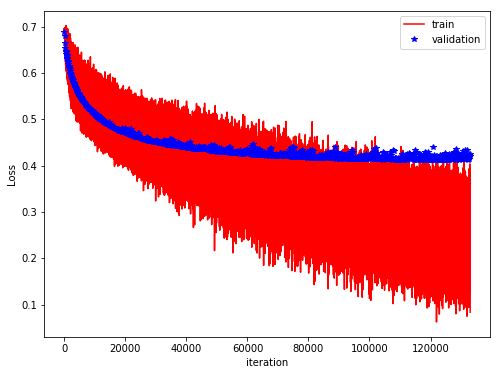

In [48]:
import matplotlib.pyplot as plt
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (8,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 100 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('loss.png') 
plt.show()

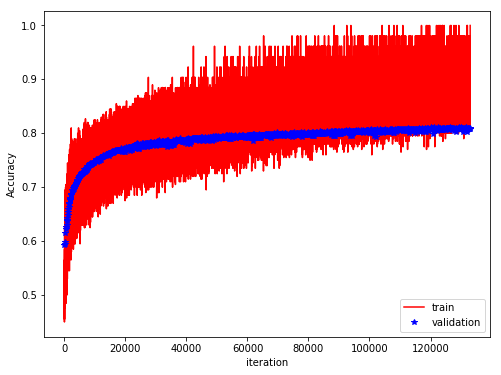

In [49]:
# Plot Accuracies
plt.figure(figsize = (8,6))
plt.plot(t, np.array(train_acc), 'r-', t[t % 100 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuracy")
plt.legend(['train', 'validation'], loc='lower right')
plt.savefig('accuracy.png') 
plt.show()

In [25]:
testStrings = '''4092,3677,1
4556,4555,1
4408,4242,1
62210,4133,1
4459,84509,1
6750,2896,1
3942,7158,1
3754,65157,1
3084,65157,1
6985,65157,1
3061,65157,1
27939,65157,1
4139,2915,1
3058,2937,1
4047,2937,1
7335,3010,1
3375,9343,1
4150,45921,1'''

X_test = []
y_test = []
X_test_reverse = []

for line in testStrings.splitlines():
    word = line.replace("\r\n", "").split(",")
    X_test.append([word[0], word[1]])
    X_test_reverse.append([word[1], word[0]])
    y_test.append(int(word[2]))
#     print(word)
#     print(vector_model.docvecs[word[0]])
#     print(vector_model.docvecs[word[1]])

print(len(X_test))

18


In [26]:
print(X_test)
print(y_test)

[['4092', '3677'], ['4556', '4555'], ['4408', '4242'], ['62210', '4133'], ['4459', '84509'], ['6750', '2896'], ['3942', '7158'], ['3754', '65157'], ['3084', '65157'], ['6985', '65157'], ['3061', '65157'], ['27939', '65157'], ['4139', '2915'], ['3058', '2937'], ['4047', '2937'], ['7335', '3010'], ['3375', '9343'], ['4150', '45921']]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [27]:
for pair in X_test:
    if pair in X_train or pair in X_validation:
        print(pair, ' yes')
        X_test.remove(pair)

print(len(X_test))

['7335', '3010']  yes
17


In [43]:
test_acc = []
batch_size = len(X_test)
with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints-cnn/har.ckpt
Test accuracy: 0.235294


In [32]:
print("\nTesting left pairs: ")
print(len(leftPairList))

20614


In [35]:
left_idpairs_list, left_label_list= readFromPairList([], leftPairList)

In [42]:
test_acc = []
batch_size = len(X_test)
with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    for x_t, y_t in get_batches(left_idpairs_list, left_label_list, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints-cnn/har.ckpt
Test accuracy: 0.832016
